In [1]:
import networkx as nx
import random
import numpy as np
from numpy.linalg import matrix_power
from statistics import mean
from collections import Counter
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
from cached_method import cached_method

In [29]:
N = 12   # Number of vertices in the graph.
M = N*(N-1)//2  # Number of edges in the graph.
punish_value = 100000000

class MYModel(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()

        # Deal with the state and one-hot move vectors separately, since we can do this efficiently.
        self.first_state = nn.Linear(M, layer_dims[0])
        self.first_move = nn.Linear(M, layer_dims[0], bias=False)

        self.layers = nn.ModuleList([
            nn.Linear(a, b)
            for a, b in zip(layer_dims, layer_dims[1:])
        ])

        self.fully_conn = nn.Linear(layer_dims[-1], 1)

    def forward(self, state, move):
        x = self.first_state(state) + self.first_move(move)
        x = nn.functional.relu(x)

        for linear in self.layers:
            x = linear(x)
            x = nn.functional.relu(x)

        x = self.fully_conn(x)
        x = torch.sigmoid(x)
        return x

In [30]:
def board_to_adj(board):
    """
    Input: A tensor of shape (*, M), giving a (batched) 01-sequence of edges.
    Output: A tensor of shape (*, N, N), giving a (batched) adjacency matrix.
    """
    adj = np.zeros([*board.shape[:-1], N, N], dtype=np.int8)
    count = 0
    for i in range(N):
        for j in range(i+1, N):
            adj[..., i, j] = adj[..., j, i] = board[..., count] != 0
            count += 1

    return adj

def display_adj(adj):
    #print(adj)
    G = nx.convert_matrix.from_numpy_array(adj)
    plt.clf()
    plt.axis('equal')
    nx.draw_circular(nx.complement(G))
    plt.savefig("mygraph.png")

In [31]:
def f_vector(adj):
    G = nx.convert_matrix.from_numpy_array(adj)
    faces_count = Counter([len(elm) for elm in nx.enumerate_all_cliques(G)])
    f_vec = [faces_count[i] for i in range(len(faces_count)+1)]
    f_vec[0] = 1
    return f_vec
    """
    d = max(list_faces_and_count)[0]
    f_vec = [(pair[1]) for pair in list_faces_and_count]
    f_vec.insert(0,1)
    return f_vec
    if cliques == True:
        return f_vec, d, list_of_all_cliques
    else:
        return f_vec, d
    """

def h_vector(f_vec):
    h_vec = []
    d = len(f_vec)-1

    for k in range(d+1):
        h_k = 0
        for i in range(k+1):
            h_k += (-1)**(k-i)*math.comb(d-i,k-i)*f_vec[i]
        h_vec.append(h_k)
    
    return h_vec

def is_symmetric(h_vec):
    d = len(h_vec)
    split_index = (len(h_vec)-1)//2
    is_symm = True
    
    if d % 2 != 0:
        for i in range(split_index):
            if h_vec[i] == h_vec[-(i+1)]:
                continue
            else:
                is_symm = False
                break
    elif d % 2 == 0:
        for i in range(split_index+1):
            if h_vec[i] == h_vec[-(i+1)]:
                continue
            else:
                is_symm = False
                break
    
    return is_symm

#print(is_symmetric([1, 9, 13, 9, 0]))

In [32]:
def gamma_vector(h_vec):
    gam_vec = []
    n = len(h_vec)-1
    d = n//2

    # gamma 0
    gam_vec.append(h_vec[0])

    # gamma 1 to d
    for i in range(1,d+1):
        g_k = h_vec[i]
        for j in range(i):
            g_k -= math.comb(n-2*j,i-j)*gam_vec[j]
        gam_vec.append(g_k)

    return gam_vec

#print(gamma_vector([1,2,3,3,2,1]))
# adj = np.array([[0,1,1,0],
#                 [1,0,0,1],
#                 [1,0,0,1],
#                 [0,1,1,0],])
# print(gamma_vector(h_vector(f_vector(adj))))

In [33]:
def play_games(agent, k_games):
    """
    Play k_games using the agent to give probability distributions on each move.
    """

    board = np.zeros((k_games, M), dtype=np.float32)
    moveid = torch.eye(M)

    for step in range(M):
        with torch.no_grad():
          prob = agent(torch.from_numpy(board), moveid[step:step+1, :]).view(k_games).numpy()

        board[:, step] = np.random.rand(k_games) < prob

    return board

In [34]:
def reinforce_games(
    model,
    optimiser,
    games,           # (n_games, M)
    batch_size=90,
):
    """
    Given a list of completed games, reinforce each move in each game.
    """
    n_games, _ = games.shape
    #moveid = torch.eye(M)

    # Unpack the games into (state, move, actions).
    states = torch.zeros((n_games, M, M))
    moveids = torch.zeros((n_games, M, M))
    actions = torch.zeros((n_games, M, 1))
    for t in range(M):
        moveids[:, t, t] = 1
        states[:, t+1:, t] = torch.from_numpy(games[:, None, t])
        actions[:, t, 0] = torch.from_numpy(games[:, t])

    # Reshape these so that we can shuffle the moves between games.
    states = states.flatten(end_dim=1)
    moveids = moveids.flatten(end_dim=1)
    actions = actions.flatten(end_dim=1)

    # Reinforce
    criterion = nn.BCELoss()
    shuffle = torch.randperm(n_games * M)
    for i in range(0, n_games * M, batch_size):
        batch = shuffle[i:i+batch_size]

        optimiser.zero_grad()
        predicted = model(states[batch], moveids[batch])
        loss = criterion(predicted, actions[batch])
        loss.backward()
        optimiser.step()

In [36]:
# Number of new games to play each round.
K_GAMES = 500

# Create a fresh network, and specify its architecture.
model = MYModel([32, 12, 4])

# The learning rate should be increased if convergence is too slow, but decreased if
# the algorithm keeps getting stuck in local minima.
optimiser = torch.optim.Adam(model.parameters(), lr=0.0009)

# The percentage of K_GAMES to reinforce.
KEEP_TOP = int(round(K_GAMES * 0.1))

# The scoring function to use
def score_fn(adj):

    # Check if graph is connected
    #conn = Main.check_connected(adj)
    
    if np.sum(adj) < N: #or np.sum(adj) > 26:
        return punish_value
    else:
        G = nx.convert_matrix.from_numpy_array(adj)
        if nx.node_connectivity(G) == 0:
            return int(punish_value/2)
        if nx.node_connectivity(G) == 1:
            return int(punish_value/4)
        if nx.node_connectivity(G) == 2:
            return int(punish_value/5)
        
        f_vec = f_vector(adj)
        h_vec = h_vector(f_vec)
        
        d = len(h_vec)-1
        neg_components = abs(sum([h for h in h_vec if h < 0]))

        if neg_components > 0:
            return neg_components*10000

        if 6 < d+1 < 8:
            t = sum([abs(h_vec[d-i]-h_vec[i]) for i in range(d//2+1)])
            if t > 0:
                return 100*t
            elif t == 0:
                gam_vec = gamma_vector(h_vec)
                gam_min = min(gam_vec)
                return gam_min
        else:
            return neg_components + 10000

"""
        if np.sum(l)==0:
            return punish_value
        else:
            if not is_unimodal(l):
                return -1000
            else:
                max_pos = l.index(max(l))
                if len(l) > max_pos+2:
                    return l[max_pos-1]-l[max_pos-2]
                else:
                    return int(punish_value/2)

            diff_vec = []
            for i in range(max_pos+1,len(l)):
                if i != len(l)-1:
                    diff = l[i]-l[i+1]
                    diff_vec.append(diff)
            
            if diff_vec !=[]:
                return min(diff_vec)
            else:
                return punish_value

"""

'\n        if np.sum(l)==0:\n            return punish_value\n        else:\n            if not is_unimodal(l):\n                return -1000\n            else:\n                max_pos = l.index(max(l))\n                if len(l) > max_pos+2:\n                    return l[max_pos-1]-l[max_pos-2]\n                else:\n                    return int(punish_value/2)\n\n            diff_vec = []\n            for i in range(max_pos+1,len(l)):\n                if i != len(l)-1:\n                    diff = l[i]-l[i+1]\n                    diff_vec.append(diff)\n            \n            if diff_vec !=[]:\n                return min(diff_vec)\n            else:\n                return punish_value\n\n'

In [37]:
# This cell can be re-run without resetting the model. 
top_games = np.ones((0, M), dtype=np.float32)

def run():
    # Keep only the top so many games here.
    global top_games
    for i in range(201):
        # Play some new games.
        new_games = play_games(model, K_GAMES)

        # Mix these games into our pot of the best games so far.
        games = np.concatenate([top_games, new_games], axis=0)

        # Score the games, and rearrange into descending order by score.
        scores = []
        for game in games:
            adj = board_to_adj(game)
            score = score_fn(adj)
            scores.append(score)
        
        scores = np.array(scores).astype(int)
        order = np.argsort(scores)[:KEEP_TOP]
        top_games = games[order]
        """
        if scores[order[0]] < 0:
            print("Found somehting not unimodal:")
            print(board_to_adj(top_games[0]))
            display_adj(board_to_adj(top_games[0]))
            break
        """
        # Train
        reinforce_games(model, optimiser, top_games, batch_size=90)

        # Display progress
        if i % 10 == 0:
            top_adj = board_to_adj(top_games[:3])
            print("-------------------------")
            print("-------------------------")
            print("Round: ",i)
            print("-------------------------")
            for game in top_adj:
                print(f"Scores: {score_fn(game)}")
                #if score_fn(game) < 100000000/5:
                print(f"h-vec: {h_vector(f_vector(game))}")
                print(f"gam-vec: {gamma_vector(h_vector(f_vector(game)))}")

            display_adj(board_to_adj(top_games[0]))

    print(board_to_adj(top_games[0]))

-------------------------
-------------------------
Round:  0
-------------------------
Scores: 600
h-vec: [1, 5, 0, 0, 0, 0, 0, 0]
gam-vec: [1, -2, -11, 18]
Scores: 600
h-vec: [1, 5, 0, 1, 1, 0, 0, 0]
gam-vec: [1, -2, -11, 19]
Scores: 600
h-vec: [1, 5, 0, 0, 0, 0, 0, 0]
gam-vec: [1, -2, -11, 18]
-------------------------
-------------------------
Round:  10
-------------------------
Scores: 600
h-vec: [1, 5, 0, 0, 0, 0, 0, 0]
gam-vec: [1, -2, -11, 18]
Scores: 600
h-vec: [1, 5, 0, 1, 1, 0, 0, 0]
gam-vec: [1, -2, -11, 19]
Scores: 600
h-vec: [1, 5, 0, 1, 1, 0, 0, 0]
gam-vec: [1, -2, -11, 19]
-------------------------
-------------------------
Round:  20
-------------------------
Scores: 600
h-vec: [1, 5, 0, 0, 0, 0, 0, 0]
gam-vec: [1, -2, -11, 18]
Scores: 600
h-vec: [1, 5, 0, 1, 1, 0, 0, 0]
gam-vec: [1, -2, -11, 19]
Scores: 600
h-vec: [1, 5, 0, 1, 1, 0, 0, 0]
gam-vec: [1, -2, -11, 19]
-------------------------
-------------------------
Round:  30
-------------------------
Scores: 600
h-v

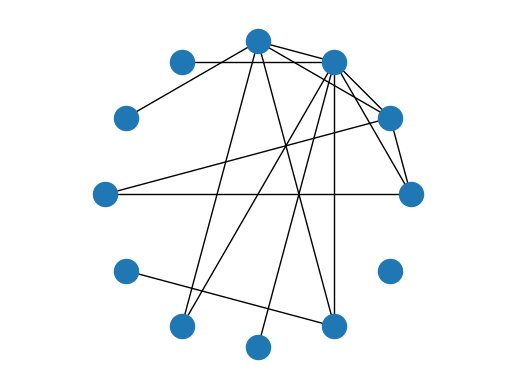

In [42]:
run()

In [40]:
adj = np.array([[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
 [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
 [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0],
 [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

h_vector(f_vector(adj)), gamma_vector(h_vector(f_vector(adj)))

([1, 11, 18, 11, 1], [1, 7, -2])

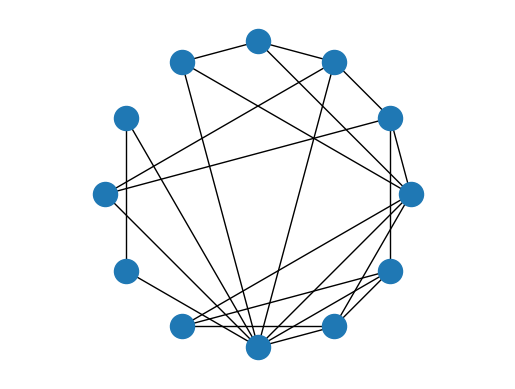

In [41]:
adj_1 = np.array([[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
 [1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1],
 [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
 [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1],
 [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])

display_adj(adj_1)